<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Index_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index Pairwise Correlations
---
### Initialize the Workspace
This is done by bringing in a standard library package, which you can find here [my_library.py](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/my_library.py). This needs to be imported into the workspace of the project, and then executed. For brevity, we also turn off `UserWarning` and `FutureWarning`. You can skip that step if you want to.

In [1]:
from my_library import *

17:39:55 Starting...
17:39:55 Installing yfinance into Google notebook...
17:40:00 Installing arch into Google notebook...
17:40:07 Initialized.


In [2]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

### Store Results in a DataFrame for Meta-Analysis

In [2]:
try:
    raise Break # uncomment to reset meta dataframe
    display(meta:=pd.read_pickle("/content/drive/MyDrive/meta.pickle"))
    nprint("Read prior meta-analysis results from Google Drive.")

except:
    meta=pd.DataFrame({("Name","Filter"):[],"N":[],"N*":[],"rho":[]}).set_index(("Name","Filter"))
    nprint("Created empty DataFrame for meta-analysis results.")

N         N*       rho
Name             Filter                             
Dow                        30.0   5.179205  0.165255
S&P 500                   502.0   4.901689  0.202423
S&P MidCap 400            401.0   3.372589  0.294749
S&P SmallCap 600          602.0   3.497499  0.284730
S&P 900                   904.0   3.964192  0.251430
S&P 1500                 1506.0   4.115399  0.242487
NASDAQ-100                101.0   5.634579  0.169250
                 Up       101.0  12.755672  0.069180
                 Down     101.0  10.703658  0.084360
Dow              Up        30.0  10.027255  0.068684
                 Down      30.0   9.700549  0.072159
S&P 500          Up       503.0  11.658441  0.083954
                 Down     503.0   9.573288  0.102673
S&P MidCap 400   Up       401.0   7.906424  0.124296
                 Down     401.0   5.637069  0.175341
S&P SmallCap 600 Up       602.0   5.397453  0.183917
                 Down     602.0  10.281668  0.095758
S&P 900          Up       904.0  10.130995  0.097709

17:40:13 Read prior meta-analysis results from Google Drive.


### Load List of Index Members
---
This has been set up to allow you to select one of the known indices by setting that value for `indexname`. In the future, more indices might be added via similar code branches.

In [109]:
nprint("Getting members of %s index." % (indexname:='Dow')) # choose from'Dow','S&P 500','NASDAQ-100','S&P MidCap 400','S&P SmallCap 600','S&P 900','S&P 1500'

def loadindex(indexname):
    """Load the specified index and return the members and the first date for data extraction."""

    if indexname=='S&P 500':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        first_date=index['Date added'].max() # add data is in table returned

    elif indexname=='NASDAQ-100':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4].set_index("Ticker"))
        first_date=datetime.now().strftime("%Y-01-02") # NASDAQ rebalances (normally) on the first day of the year. Jan'1st. is *always* a holiday

    elif indexname=='S&P MidCap 400':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        updates=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')[1].set_index(("Date","Date"))
        updates.index=list(map(lambda x:pd.Period(x.split('[')[0],'D'),updates.index))
        first_date=str(updates.index.max())

    elif indexname=='S&P SmallCap 600':
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[0].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        updates=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[1].set_index(("Date","Date"))
        updates.index=list(map(lambda x:pd.Period(x.split('[')[0],'D'),updates.index))
        first_date=str(updates.index.max())

    elif indexname=='S&P 900': # union of S&P 500 and S&P MidCap 400
        sp500,dt500=loadindex('S&P 500')
        sp400,dt400=loadindex('S&P MidCap 400')
        columns=list(set(sp500.columns).intersection(set(sp400.columns)))
        index=pd.concat([sp500[columns],sp400[columns]]).sort_index()
        first_date=max([dt500,dt400])

    elif indexname=='S&P 1500': # union of S&P 500, S&P MidCap 400, and S&P SmallCap 600
        sp900,dt900=loadindex('S&P 900')
        sp600,dt600=loadindex('S&P SmallCap 600')
        columns=list(set(sp900.columns).intersection(set(sp600.columns)))
        index=pd.concat([sp900[columns],sp600[columns]]).sort_index()
        first_date=max([dt900,dt600])

    elif indexname=='Dow': # Dow Jones
        display(index:=pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1].rename(columns={"Symbol":"Ticker"}).set_index("Ticker"))
        first_date=index['Date added'].max()

    else:
        raise ValueError("Don't know how to load members of %s Index!" % indexname)

    return index[~index.index.duplicated()],first_date # drop duplicates in case some exist

index,first_date=loadindex(indexname)
nprint("Total of %d stocks. First date for data extract is %s." % (index.shape[0],first_date))

20:02:22 Getting members of S&P 900 index.


,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969


,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,SEC filings
Ticker,,,,,
AA,Alcoa,Materials,Aluminum,"Pittsburgh, Pennsylvania",reports
AAON,AAON,Industrials,Building Products,"Tulsa, Oklahoma",reports
ACHC,Acadia Healthcare,Health Care,Health Care Facilities,"Franklin, Tennessee",reports
ACM,AECOM,Industrials,Construction & Engineering,"Dallas, Texas",reports
ADC,Agree Realty,Real Estate,Retail REITs,"Bloomfield Hills, Michigan",reports
...,...,...,...,...,...
XRAY,Dentsply Sirona,Health Care,Health Care Supplies,"Charlotte, North Carolina",reports
YETI,Yeti,Consumer Discretionary,Leisure Products,"Austin, Texas",reports
ZD,Ziff Davis,Communication Services,Advertising,"New York City, New York",reports


20:02:24 Total of 904 stocks. First date for data extract is 2024-07-26.


### Measure Correlations for a Random Sample of Index Member Pairs
---
This analysis is survivorship bias free because data is taken strictly from the last index rebalance only.

In [110]:
results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks, starting on {:s}.".format(first_date))
data=download(list(map(lambda x:x.replace(".","-"),index.index)),first_date) # Yahoo! Finance uses - for subclasses of equity

for i in tqdm(results.index):
    df=data["Adj Close"].sample(2,axis=1)
    df.columns=pd.MultiIndex.from_product([["Adj Close"],df.columns])

    if df.shape[0]<10:
        continue

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)
    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0]
    results.loc[i,"Ticker 2"]=tickers[1]
    results.loc[i,"Correlation"]=df["Return"].corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
display(results)

20:02:24 Getting daily data for all index stocks, starting on 2024-07-26.


[*********************100%***********************]  904 of 904 completed


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-110-f14c7a9c5a0e>:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-110-f14c7a9c5a0e>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())


,,Correlation,Sample
Ticker 1,Ticker 2,,
EXEL,DUK,22.123233,37.0
RGEN,KMPR,-0.415312,37.0
DE,CME,-20.939663,37.0
DTM,NOW,44.468425,37.0
LANC,CNX,6.330418,37.0
...,...,...,...
LYB,AZO,11.186603,37.0
M,SWN,46.612654,37.0
AMH,RH,21.548590,37.0


### Make a Histogram

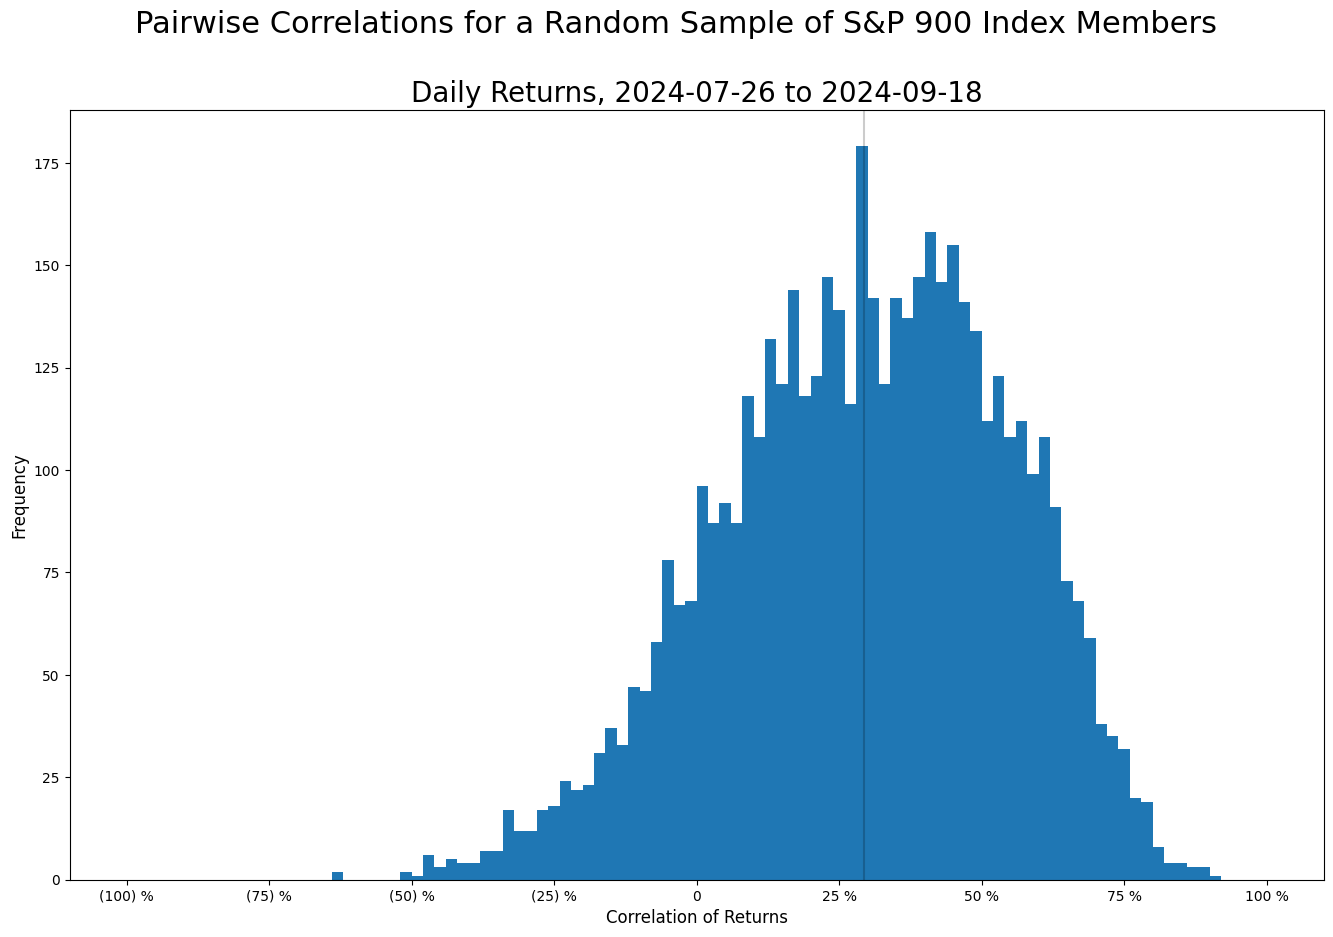

In [111]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
bins,counts,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Execute the $N^*$ vs. $N$ Analysis
---
$N^*$ is the effective degrees of freedom found within a portfolio of size $N$. This is computed by comparing the variance of the portfolio returns to the variance we would expect if all the stocks were independent.

In [112]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials. This may take about {:.1f} minutes...".format(n,n/2.38/60)) # approx empirical timings

if (filter:=None) is not None: # choose "Up", "Down" or None
    nprint("Limiting analysis to portfolio %s days only." % filter.lower())
    #returns=closes.pct_change().iloc[1:]*hundred
    #select=returns.mean(axis=1)>zero if filter=='Up' else returns.mean(axis=1)<zero if filter=='Down' else ~returns.mean(axis=1).isna()

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[np.random.choice(closes.columns,np.random.randint(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    select=returns["Portfolio"]>zero if filter=="Up" else returns["Portfolio"]<zero if filter=="Down" else ~returns["Portfolio"].isna()
    results.loc[i,"Assets"]=returns.shape[1]-1 # number of assets we ended up with
    results.loc[i,"Independent"]=returns.loc[select,[a for a in returns if a!="Portfolio"]].var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    results.loc[i,"Portfolio"]=returns.loc[select,'Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

20:07:20 Getting daily data for all index stocks, starting on 2024-07-26.
20:07:20 Beginning analysis for 1,000 trials. This may take about 7.0 minutes...
20:07:20 Limiting analysis to portfolio up days only.


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Independent,Effective D.o.F.
Sample,,,,
1,237.0,0.292051,0.013843,11.233759
2,257.0,0.327007,0.013232,10.399417
3,374.0,0.337772,0.009000,9.965336
4,849.0,0.340073,0.004084,10.195378
5,584.0,0.331511,0.005883,10.363612
...,...,...,...,...
996,252.0,0.413132,0.014176,8.647145
997,245.0,0.362886,0.013948,9.416811
998,66.0,0.371620,0.054322,9.647680


20:20:13 Done.


### Make a Plot

20:20:13 Up Days: Effective D.o.F. Limit 10.13, Implied Correlation 9.77 %.


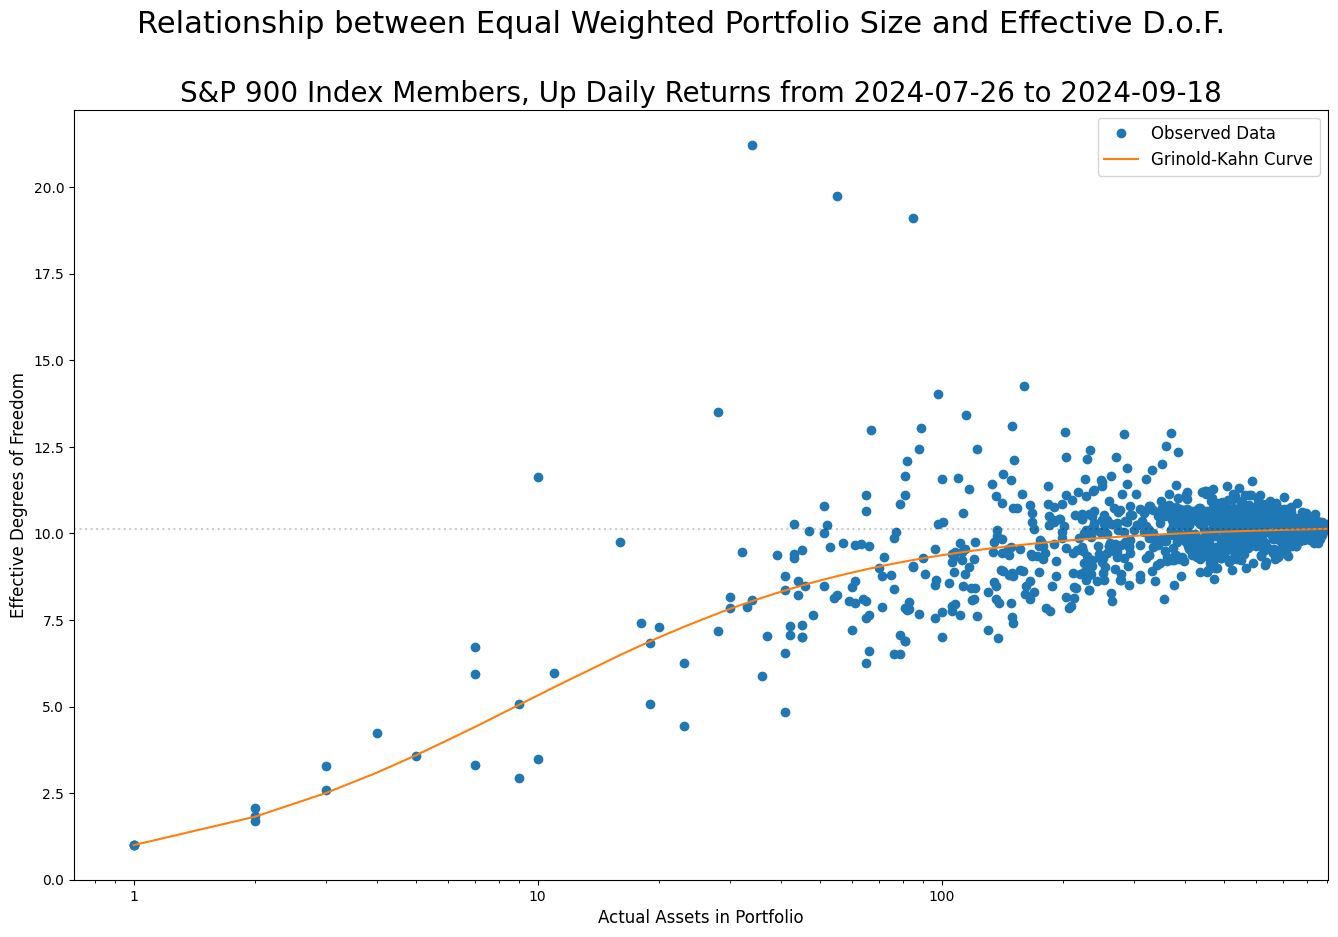

In [113]:
Nstar,Nact=tuple(results.sort_values("Assets").iloc[-1][["Effective D.o.F.","Assets"]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("{:s} Days: Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(filter if filter is not None else "All",Nstar,rho*hundred))
meta=pd.concat([meta,pd.DataFrame({
    "Name":[(indexname,filter if filter is not None else "")],
     "N":[Nact],
    "N*":[Nstar],
    "rho":[rho]
}).set_index("Name")])

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.append([] if max(x)>100 else [zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Grinold-Kahn Curve')
plot.set_xscale('log' if max(x)>100 else 'linear')
plot.set_ylim(zero,None)
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("%s Index Members, %s Daily Returns from %s to %s" % (indexname,filter if filter is not None else "All",first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
plot.xaxis.set_major_formatter(CountLabels())
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Meta-Analysis
---

In [114]:
meta.index=pd.MultiIndex.from_tuples(meta.index)
meta.index.names=("Name","Filter")
meta=meta.loc[~meta.index.duplicated(keep='last')]
display(meta.sort_values("N",ascending=True))

try:
    meta.to_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Saved meta-analysis results to Google Drive.")

except:
    raise RuntimeError("You need to mount your Google Drive to save results.")

N         N*       rho
Name             Filter                             
Dow                        30.0   5.179205  0.165255
                 Down      30.0   9.700549  0.072159
                 Up        30.0  10.027255  0.068684
NASDAQ-100       Up       101.0  12.755672  0.069180
                          101.0   5.634579  0.169250
                 Down     101.0  10.703658  0.084360
S&P MidCap 400            401.0   3.372589  0.294749
                 Up       401.0   7.906424  0.124296
                 Down     401.0   5.637069  0.175341
S&P 500                   502.0   4.901689  0.202423
                 Up       503.0  11.658441  0.083954
                 Down     503.0   9.573288  0.102673
S&P SmallCap 600          602.0   3.497499  0.284730
                 Down     602.0  10.281668  0.095758
                 Up       602.0   5.397453  0.183917
S&P 900                   904.0   3.964192  0.251430
                 Up       904.0  10.130995  0.097709
S&P 1500                 1506.0   4.115399  0.242487

20:20:16 Saved meta-analysis results to Google Drive.


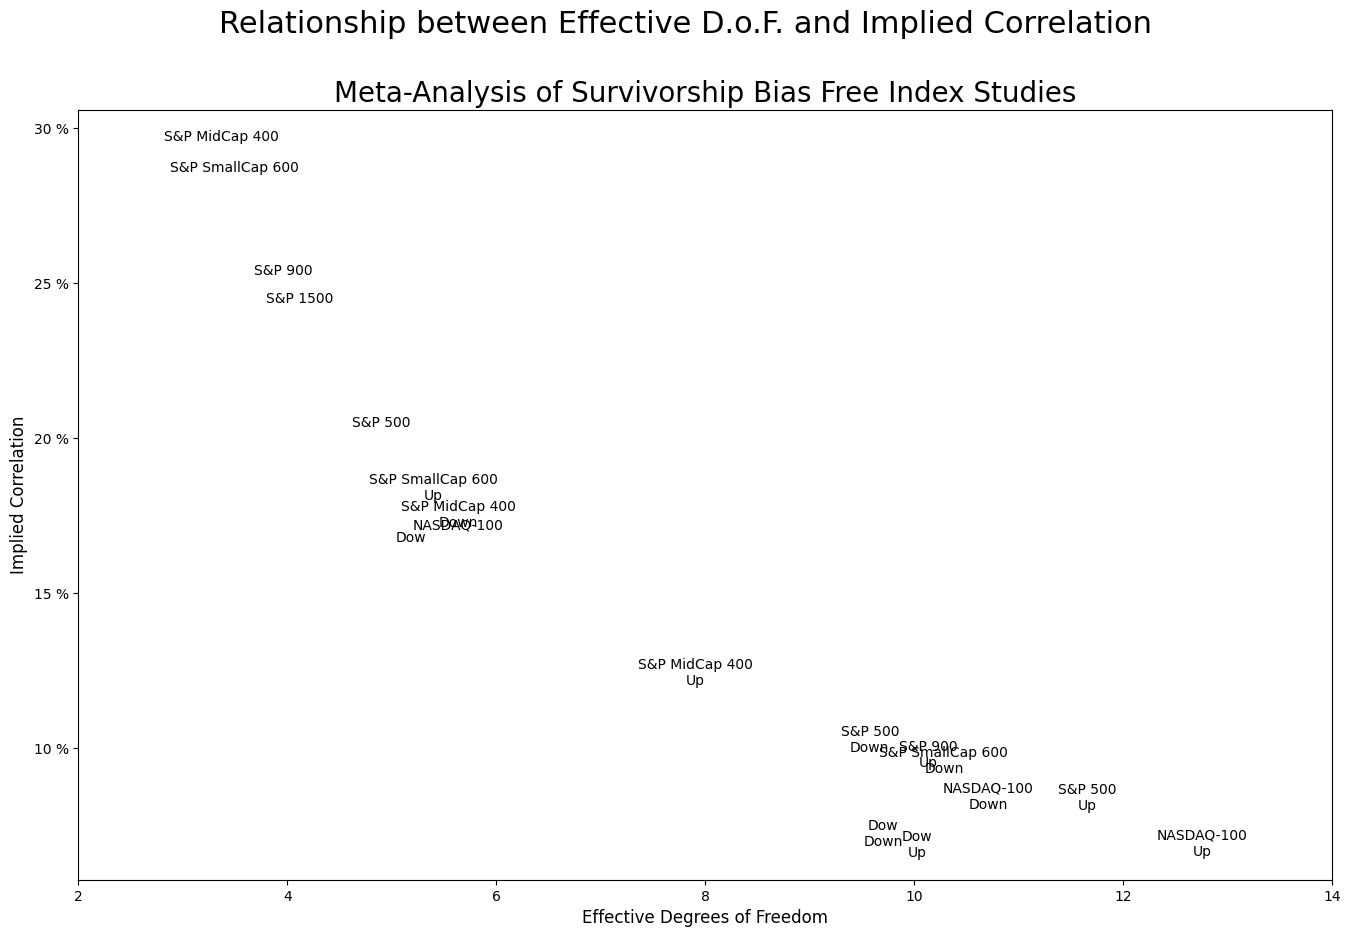

In [115]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=meta["N*"].to_numpy(),y:=meta["rho"].to_numpy()*hundred,'o',label='Observed Data',alpha=zero)
plot.set_xlabel("Effective Degrees of Freedom",fontsize=12)
plot.set_ylabel("Implied Correlation",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Relationship between Effective D.o.F. and Implied Correlation",fontsize=22)
plot.set_title("Meta-Analysis of Survivorship Bias Free Index Studies",fontsize=20)
plot.set_xlim(np.floor(meta["N*"]).min()-one,np.ceil(meta["N*"]).max()+one)

for i in meta.index:
    plot.text(x:=meta.loc[i,"N*"],y:=meta.loc[i,"rho"]*hundred,s:="\n".join(i),ha='center',va='center',fontsize=10)

figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### $\LaTeX$ Code for the Formulae in the Articles
---

$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$

$$
\sum_{N=1}^M\begin{pmatrix}M\\ N\end{pmatrix}=2^M-1
$$

$$
2^{503}-1\approx3.3\times10^{150}
$$

$$
\mathbb{V}[r_{it},r_{jt}]=\sigma_{it}\sigma_{jt}\rho\;\Leftrightarrow\;V_t=S_tRS_t\;\mathrm{where}\;R=\begin{pmatrix}
1&\rho&\cdots&\rho\\
\rho&1&\cdots&\rho\\
\vdots&&\ddots&\vdots\\
\rho&\rho&\cdots&1
\end{pmatrix}\;\mathrm{and}\;
S_t=\begin{pmatrix}
\sigma_{1t}&0&\cdots&0\\
0&\sigma_{2t}&\cdots&0\\
\vdots&&\ddots&\vdots\\
0&0&\cdots&\sigma_{Nt}
\end{pmatrix}
$$

In [116]:
meta.xs('',axis=0,level=1)

,N,N*,rho
Name,,,
Dow,30.0,5.179205,0.165255
S&P 500,502.0,4.901689,0.202423
S&P MidCap 400,401.0,3.372589,0.294749
S&P SmallCap 600,602.0,3.497499,0.284730
S&P 900,904.0,3.964192,0.251430
S&P 1500,1506.0,4.115399,0.242487
NASDAQ-100,101.0,5.634579,0.169250
